## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [50]:
# readind the data from the csv file
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [51]:
#knowing the shape of my data
df.shape[0]

294478

c. The number of unique users in the dataset.

In [52]:
# know the number of unique values in the user_id column
df.user_id.nunique()

290584

d. The proportion of users converted.

In [53]:
len(df[df['converted']==1])/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [54]:
len(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False])

3893


f. Do any of the rows have missing values?

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No Null values as shown from the length of every column**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [56]:
df2=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
len(df2)

290585

In [57]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [58]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [59]:
df2[(df2['user_id'].duplicated())==True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [60]:
df2[(df2['user_id'].duplicated())==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [61]:
df2.drop(2893,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
len(df2)

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [63]:
len(df2.query('converted==1'))/len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [64]:
len(df2.query('converted==1 and group=="control"'))/len(df2[df2['group']=='control'])

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [65]:
len(df2.query('converted==1 and group=="treatment"'))/len(df2[df2['group']=='treatment'])

0.11880806551510564

d. What is the probability that an individual received the new page?

In [66]:
len(df2.query('landing_page=="new_page"'))/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**I think the conversion rate is similar in both groups because the difference in conversion rate is so small between the two groups so we can't give any opinion due to lack if statistecal evidence so that we need the a/b test and we will do it in the next part**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<center> $p_{old}$  $\geq$ $p_{new}$</center>
    <center> $p_{old}$  $\lt$ $p_{new}$ </center>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [67]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [68]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [69]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [70]:
n_new=len(df2.query('group=="treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [71]:
n_old=len(df2.query('group=="control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [72]:
new_page_converted =np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.12023948799119125

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [73]:
old_page_converted =np.random.binomial(1,p_old,n_old)

old_page_converted.mean()

0.11926428679598551

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [74]:
new_page_converted.mean() - old_page_converted.mean()

0.00097520119520573545

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [75]:
p_diffs=[]

new_page_converted =np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted =np.random.binomial(n_old,p_old,10000)/n_old
p_diffs=(new_page_converted-old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  2.00000000e+00,   2.60000000e+01,   2.13000000e+02,
          9.02000000e+02,   2.06600000e+03,   2.88900000e+03,
          2.38600000e+03,   1.13700000e+03,   3.10000000e+02,
          6.90000000e+01]),
 array([-0.00510235, -0.00419862, -0.0032949 , -0.00239117, -0.00148744,
        -0.00058372,  0.00032001,  0.00122374,  0.00212747,  0.00303119,
         0.00393492]),
 <a list of 10 Patch objects>)

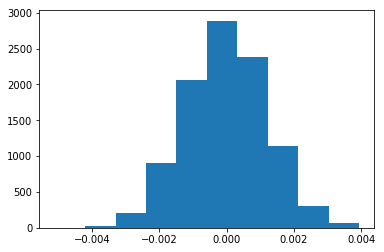

In [76]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [77]:
control_df=df2.query("group=='control'")
treatment_df=df2.query("group=='treatment'")
obs_diff=treatment_df.converted.mean() - control_df.converted.mean()

obs_diff

-0.0015782389853555567

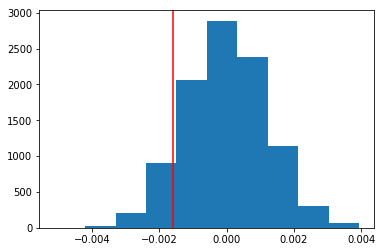

In [78]:
plt.hist(p_diffs)
plt.axvline(obs_diff,c='red')

In [79]:
(p_diffs>obs_diff).mean()

0.90139999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**After calculating the p-value and it is more than %90 so we can not reject the null hypothesis because there is no enough evidence that the new page makes more convertions**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [80]:
import statsmodels.api as sm

convert_old =len( df2.query('converted==1 and landing_page=="old_page"'))
convert_new = len(df2.query('converted==1 and landing_page=="new_page"'))

n_old = len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [81]:
from statsmodels.stats.proportion import proportions_ztest
counts =[convert_old,convert_new]
nobs = [n_old,n_new]
stat, pval = proportions_ztest(counts, nobs,value=None, alternative='smaller', prop_var=False)
stat, pval

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p_value is more than 0.05 so we can't reject the null hypothesis** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We will use logistic regression because we have true or false values**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [82]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [83]:
#making the dummy dataand intercept column 
df2['intercept']=1
df2[['new_page','old_page']]=pd.get_dummies(df['landing_page'])
df2[['control','treatment']]=pd.get_dummies(df['group'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [84]:
# rename the treatment column from treatment to ab_page
df2.rename(columns={'treatment':'ab_page'},inplace=True)
df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [85]:
ml=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res=ml.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [86]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-03 20:49 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p_value is 0.1899** 

**The high p_value for ab_page in the regression shows that there is no correlation between the landing_page type and the convertion rate<center> $p_{old}$  $=$ $p_{new}$</center>
    <center> $p_{old}$  $\neq$ $p_{new}$ </center> and that shows that $p_{old}$  $=$ $p_{new}$ which is our null hypothesis which is the null hypothesis of a two tailed test so we can't reject it**
    
**It is different from the results from part II beacause it was one tailed test because the hypothesis have the inequality signs**





f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There are many other things could affect our hypothesis and it is good to know every aspect can affect our conversion rate to see the bigger picture for the convertion rate** 

**Some disadvantages may appear if thier is multicollinearity between the columns on our x-axis**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [87]:
countries_df=pd.read_csv('countries.csv')
df2_new=countries_df.set_index('user_id').join(df2.set_index('user_id'))

In [88]:
df2_new[['CA',"UK","US"]]=pd.get_dummies(df2_new['country'])
df2_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [89]:
df2_new['uk_ab_page']=df2_new["UK"]*df2_new['ab_page']
df2_new['ca_ab_page']=df2_new["CA"]*df2_new['ab_page']

In [90]:
ml=sm.Logit(df2_new['converted'],df2_new[['intercept','ab_page',"UK",'uk_ab_page','CA','ca_ab_page']])
res=ml.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-03 20:49 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
uk_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
ca_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

**The Users from UK are more likely to convert rather than users from CA or US but the p-value is big so we keep the old page**

<a id='conclusions'></a>
## Conclusions 

>After using a/b test and regression the analysis shows that the convertion rate between old and new page is very small so it is better to keep the old page to save money and time

> I noticed that the time of the experiment is very small so you might consider collecting the data for longer time to get better data for the a/b test

> I recommend to keep the old page and invest in its developement rather than building new page from scratch 

In [91]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0